### Hilbert Space

In [1]:
from qutip import *
import numpy as np
import scipy.optimize as sciop
import matplotlib.pyplot as plt
import cython

# define idealised basis
basis_labels = {
    'cav_bin': 0,
    'spont_bin': 1,
    'g':2,
    'u':3,
    'x':4
}
N=len(basis_labels)

g_ket = basis(N, basis_labels['g'])
u_ket = basis(N, basis_labels['u'])
x_ket = basis(N, basis_labels['x'])

# define basic operators
gx_swap = basis(N, basis_labels['g']) * basis(N, basis_labels['x']).dag()
ux_swap = basis(N, basis_labels['u']) * basis(N, basis_labels['x']).dag()

g_id = fock_dm(N, basis_labels['g'])
u_id = fock_dm(N, basis_labels['u'])
x_id = fock_dm(N, basis_labels['x'])
cav_id = fock_dm(N, basis_labels['cav_bin'])
spont_id = fock_dm(N, basis_labels['spont_bin'])

cav_decay = basis(N, basis_labels['cav_bin']) * basis(N, basis_labels['g']).dag()
spont_decay = basis(N, basis_labels['spont_bin']) * basis(N, basis_labels['x']).dag()

## Parameters

In [2]:
delta_stirap = 1
delta_C = delta_stirap
delta_L = delta_stirap

gamma = 0.1
kappa = gamma*10

coops = [0.5] + list(np.logspace(1,np.log10(50), 10)) + list(np.linspace(60, 150, 10))


RUNTIME = 0.1/gamma
STEPS_PER_SEC = 1000
NUM_STEPS = round(STEPS_PER_SEC*RUNTIME + 1)
if type(RUNTIME) == float:
    if RUNTIME < 1:
        lin_factor = 1/RUNTIME
        RUNTIME = lin_factor*RUNTIME
    else:
        lin_factor = 10
        RUNTIME = np.ceil(RUNTIME*10)
t = np.linspace(0, int(RUNTIME), NUM_STEPS)
t /= lin_factor

# define pulse shape
wSTIRAP = np.pi/RUNTIME
H_args = {
    'wSTIRAP': wSTIRAP
}
flat_pulse = '1'
sin_pulse = 'np.sin(wSTIRAP*t)**2'

c_ops = [np.sqrt(gamma)*spont_decay, np.sqrt(kappa)*cav_decay]

### Efficiency Functions

In [3]:
def find_efficiency(omega, cooperativity, psi0=u_ket, pulse_shape=sin_pulse):

    g0 = (kappa*gamma*cooperativity)**0.5

    theta = np.arctan(omega/2*g0)

    H0 = delta_C*g_id + delta_L*u_id - g0*(gx_swap + gx_swap.dag())
    H1 = -omega/2*(ux_swap + ux_swap.dag())
    H=[H0, [H1, pulse_shape]]

    result = mesolve(H, psi0, t, c_ops, [], args=H_args)

    photon_emission_prob = expect(cav_id, result.states[-1])
    spont_decay_prob = expect(spont_id, result.states[-1])

    return photon_emission_prob/(photon_emission_prob + spont_decay_prob)


def find_neg_efficiency(omega, cooperativity, psi0=u_ket, pulse_shape=sin_pulse):

    g0 = (kappa*gamma*cooperativity)**0.5

    theta = np.arctan(omega/2*g0)

    H0 = delta_C*g_id + delta_L*u_id - g0*(gx_swap + gx_swap.dag())
    H1 = -omega/2*(ux_swap + ux_swap.dag())
    H=[H0, [H1, pulse_shape]]

    result = mesolve(H, psi0, t, c_ops, [], args=H_args)

    photon_emission_prob = expect(cav_id, result.states[-1])
    spont_decay_prob = expect(spont_id, result.states[-1])

    return -photon_emission_prob/(photon_emission_prob + spont_decay_prob)


In [4]:
def optimise_peak_rabi(cooperativity, omega_guess):

    sciop.minimize(find_neg_efficiency, [omega_guess, args=(cooperativity,))

In [9]:
test_coop = 2000
omegas = np.linspace(10, 1000, 10)

omg_effs = []
i=0
for omg in omegas:
    print(i)
    omg_effs.append(find_efficiency(omg, test_coop))
    i += 1

0
1
2
3
4
5
6
7
8
9


In [10]:
test_coop = 1000
omegas = np.linspace(10, 1000, 10)

omg_effs2 = []
i=0
for omg in omegas:
    print(i)
    omg_effs2.append(find_efficiency(omg, test_coop))
    i += 1

0
1
2
3
4
5
6
7
8
9


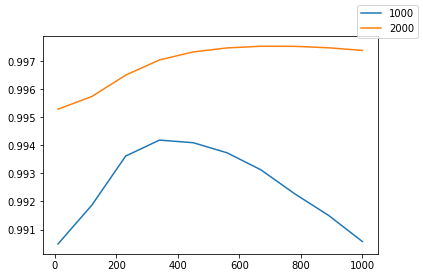

In [12]:
fig, axes = plt.subplots(1,1)
axes.plot(omegas, omg_effs2)
axes.plot(omegas, omg_effs)
fig.legend(['1000', '2000'])
# axes.set_xbound(0,900)